<a href="https://colab.research.google.com/github/sp-au-mu-nl/SpeechComm/blob/main/notebook/chap06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!wget https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/src/spcom.py
!wget https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/data/chap06.zip
!unzip -o chap06.zip
!rm chap06.zip

--2025-04-23 04:02:25--  https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/data/chap06.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/data/chap06.zip [following]
--2025-04-23 04:02:26--  https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/data/chap06.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 364631 (356K) [application/zip]
Saving to: ‘chap06.zip’

chap06.zip          100%[===================>] 356.08K  --.-KB/s    in 0.007s  

2025-04-23 04:02:26 (52.8 MB/s) - ‘chap06.zip’ saved [364631/364631]

Archive:  chap

プログラム 6.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import IPython.display
import scipy
from scipy import signal
import librosa

#import spcom

プログラム 6.2

<StemContainer object of 3 artists>

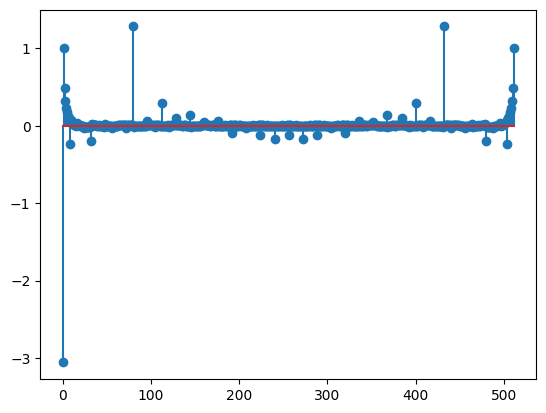

In [3]:
s,sr = librosa.load('chap06_synth_vowel.wav', sr=None)
nFFT = 512
S = np.fft.rfft(s[:nFFT]*np.hanning(nFFT))
LS = np.log(np.abs(S))
c = np.fft.irfft(LS)
plt.stem(c)

(-120.0, 120.0)

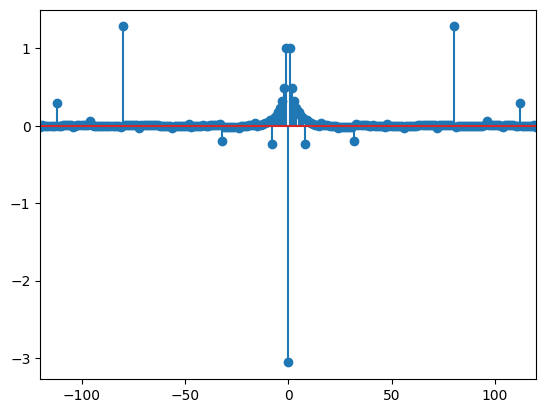

In [4]:
plt.close()
x = np.arange(len(c))-len(c)/2
plt.stem(x, np.fft.fftshift(c))
plt.xlim([-120,120])

In [5]:
np.fft.fftshift(c)[256-2:256+3]

array([ 0.49027449,  0.996928  , -3.05624003,  0.996928  ,  0.49027449])

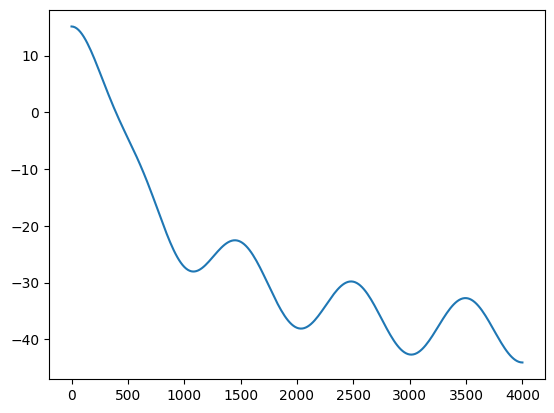

In [6]:
plt.close()
order = 14
cGVLow = c
cGVLow[order+1:-order] = 0
GVLow = np.real(np.fft.rfft(cGVLow))
f = np.fft.rfftfreq(nFFT,1/sr)
plt.plot(f,20*GVLow/np.log(10))

<StemContainer object of 3 artists>

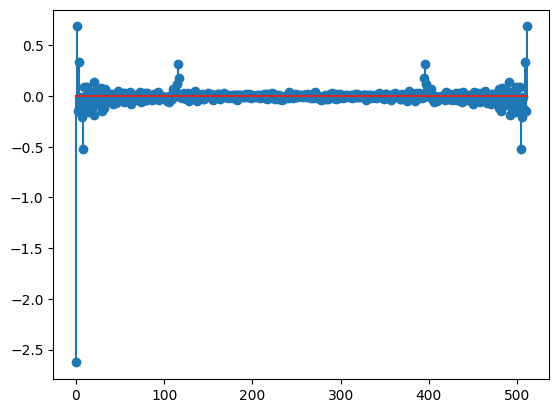

In [7]:
plt.close()

def cepstrum(S):
    LS = np.log(np.abs(S))
    return np.fft.irfft(LS)

def liftering(in_ceps, order=14):
    out_ceps = in_ceps.copy()
    out_ceps[order+1:-order] = 0
    return out_ceps

ySa, sr = librosa.load('sa48k.wav',sr=16000)
ySa = signal.lfilter([1, -0.97], 1, ySa)
nFFT = 512
yA = ySa[7000+np.arange(nFFT)]*np.hanning(nFFT)
SA = np.fft.rfft(yA)
cA = cepstrum(SA)
cALow = liftering(cA, 20)
plt.stem(cA)

<StemContainer object of 3 artists>

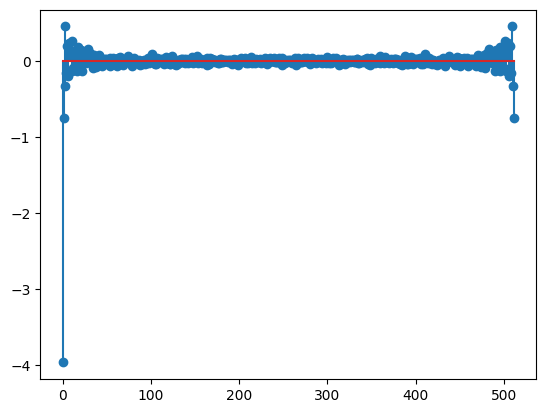

In [8]:
plt.close()
SS = np.fft.rfft(ySa[2500+np.arange(nFFT)]*np.hanning(nFFT))
cS = cepstrum(SS)
cSLow = liftering(cS, 20)
plt.stem(cS)

In [9]:
def glottalPulse(fs, T1=0.004, T2=0.002):
    t1 = np.arange(0, T1, 1/fs)
    g1 = 0.5*(1 - np.cos(2*np.pi*t1/2/T1))
    t2 = np.arange(T1, T1 + T2, 1/fs)
    g2 = np.cos(2*np.pi*(t2 - T1)/4/T2)
    return np.hstack((g1, g2))

def freqz_two_tube(f,rL,rG,r1,L,c,L1L2):
    return 0.5*(1+rG)*(1+rL)*(1*r1)*np.exp(-2j*np.pi*f*L/c)/ \
        (1+r1*rG*np.exp(-2j*np.pi*f*2*L1L2/(L1L2+1)*L/c)+ \
         r1*rL*np.exp(-2j*np.pi*f*2/(1+L1L2)*L/c)+ \
         rL*rG*np.exp(-2j*np.pi*f*2*L/c))

In [10]:
def twoTubeSynth(fs, f0=100, L=0.176, c=352, rL=0.7, rG=1, a1a2=1/8, L1L2=1.2):
    r1 = (1-a1a2)/(1+a1a2)
    g = glottalPulse(fs)
    imp_len = 1/f0
    nimp = int(np.round(imp_len*fs/2))*2
    imp = np.zeros(nimp)
    imp[0] = 1
    x_imp = np.matlib.repmat(imp, 1, int(round(1/imp_len)))
    y_glottal = signal.lfilter(g, 1, x_imp)
    f = np.arange(0, int(y_glottal.shape[1]/2))
    V = freqz_two_tube(f,rL,rG,r1,L,c,L1L2)
    S_glottal = np.fft.rfft(y_glottal)
    S = S_glottal*np.append(V, 0)
    return np.fft.irfft(S)[0,:]

In [11]:
plt.close()
yA131 = twoTubeSynth(sr, 131, 0.17, 340, 0.7, 1.0, 1/7, 1)
yA131 = signal.lfilter([1, -0.97], 1, yA131)
nFFT = 512
SA131 = np.fft.rfft(yA131[np.arange(nFFT)]*np.hanning(nFFT))
cA131 = cepstrum(SA131)
cA131Low = liftering(cA131, 20)
#plt.stem(cA131Low)

In [12]:
np.linalg.norm(cALow-cSLow)**2

np.float64(7.461067450871407)

In [13]:
np.linalg.norm(cALow-cA131Low)**2

np.float64(1.4490777304869482)

In [14]:
np.linalg.norm(cSLow-cA131Low)**2

np.float64(6.02376829147267)

In [15]:
def hz2mel(freq):
    return 1127*np.log(1 + freq/700)

def mel2hz(mel):
    return (np.exp(mel/1127) - 1)*700

In [16]:
def melbank(fs=16000, nfft=512, nbank=40, lower=0, upper=8000):
#    fs = 16000 if len(args) == 0 else args[0]
#    upper = fs/2 if len(args) < 5 else args[4]
#    lower = 0 if len(args) < 4 else args[3]
#    nbank = 40 if len(args) < 3 else args[2]
#    nfft = 512 if len(args) < 2 else args[1]

    f = np.linspace(0, fs/2, int(nfft/2)+1)

    mel_s_w = np.zeros((nbank, int(nfft/2)+1))
    mel_w_len1 = int(np.floor(400/3/(fs/nfft)))
    mel_w_inc1 = np.linspace(0, 1, int(mel_w_len1/2)+1)
    mel_w_dec1 = np.linspace(1, 0, int(mel_w_len1/2)+1)
    if mel_w_len1 % 2 == 1:
        mel_w_tri1 = np.hstack((mel_w_inc1, mel_w_dec1))
    else:
        mel_w_tri1 = np.hstack((mel_w_inc1, mel_w_dec1[1:]))
    mel_w_tri_n1 = mel_w_tri1/np.sum(mel_w_tri1)
    mel_c_idx1 = np.arange(mel_w_len1/2, 13 * mel_w_len1/2, mel_w_len1/2).astype(int)
    for w_idx1 in np.arange(len(mel_c_idx1)):
        idx1 = int(mel_c_idx1[w_idx1] - mel_w_len1/2)
        mel_s_w[w_idx1, idx1:(idx1 + mel_w_len1 +1)] = mel_w_tri_n1

    mel_upper = hz2mel(upper)
    mel_lower = hz2mel(f[mel_c_idx1[-1]])
    mel_step = (mel_upper - mel_lower)/(nbank + 1 - len(mel_c_idx1))
    mel_c_idx2 = np.round(mel2hz(np.arange(mel_lower, mel_upper+1, mel_step))/(fs/2)*(nfft/2)).astype(int)
    for w_idx2 in np.arange(len(mel_c_idx2)-2):
        c1 = mel_c_idx2[w_idx2]; c2 = mel_c_idx2[w_idx2 + 1]; c3 = mel_c_idx2[w_idx2 + 2]
        mel_s_w[w_idx2 + w_idx1 + 1, c1:(c2 + 1)] = np.linspace(0, 1, c2 - c1 + 1)
        mel_s_w[w_idx2 + w_idx1 + 1, c2:(c3 + 1)] = np.linspace(1, 0, c3 - c2 + 1)
        mel_s_w[w_idx2 + w_idx1 + 1, :] = mel_s_w[w_idx2 + w_idx1 + 1, :]/np.sum(mel_s_w[w_idx2 + w_idx1 + 1, :])

    # 応急措置 (フィルタバンクを滑らかにする)
    #w_sum = np.sum(mel_s_w, axis=0)
    #idx = np.argwhere(np.append(np.diff(w_sum) > .01, False))
    #mod_idx = idx[idx > mel_c_idx2[0]]
    #for idx in mod_idx:
    #    r_idx = np.argwhere(mel_s_w[:,mod_idx]>0)
    #    mel_s_w[r_idx, mod_idx] = mel_s_w[r_idx, mod_idx + 1]
    #

    f_c1 = mel2hz(f[mel_c_idx1])
    f_c2 = mel2hz(np.arange(mel_lower, mel_upper+1, mel_step))
    f_c = np.hstack((f_c1, f_c2[1:-1]))
    return mel_s_w, f_c

<ipython-input-17-3101cc9e80c0>:17: RuntimeWarning: divide by zero encountered in log
  plt.plot(f,np.log(np.sum(np.exp(scipy.fft.idct(mfccSA))


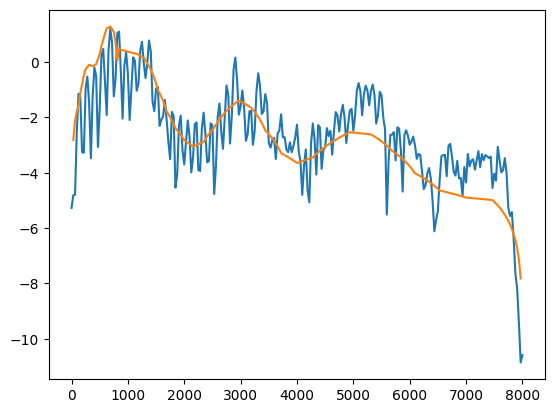

In [17]:
plt.close()

ySa, sr = librosa.load('sa48k.wav',sr=16000)
ySa = signal.lfilter([1, -0.97], 1, ySa)
nFFT = 512
yA = ySa[7000+np.arange(nFFT)]*np.hanning(nFFT)
SA = np.fft.rfft(yA)
f = np.fft.rfftfreq(nFFT,1/sr)
nBank = 40
melFilterBank, _ = melbank()
melSA = np.log(melFilterBank@np.abs(SA))
order = 13
mfccSA = scipy.fft.dct(melSA)
mfccSA[order+1:] = 0
mfccSA[0] = 0
plt.plot(f,np.log(np.abs(SA)))
plt.plot(f,np.log(np.sum(np.exp(scipy.fft.idct(mfccSA))
                                 *melFilterBank.T,axis=1)))
#fig = plt.gcf()
#fig.savefig('fig06_33.eps')